# Denoising Auto Encoder



In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from tqdm.notebook import tqdm
from scipy import ndimage

## Load FaceScrub data

In [5]:
!gdown 'https://drive.google.com/uc?id=1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk'
blob = np.load('/content/img_align_celeba_50k.npz')
x_train, x_test = blob['x_train'], blob['x_test']
dim = x_train.shape[1:]
n_valid = 2000
x_train, x_valid = x_train[:-n_valid], x_train[-n_valid:]

print(f'x_train shape: {x_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'dtype: {x_train.dtype}')

Downloading...
From: https://drive.google.com/uc?id=1Uzgc9c0MSYP4y9ia7mvwCGggjhTDEmrk
To: /content/img_align_celeba_50k.npz
100% 737M/737M [00:06<00:00, 116MB/s]
x_train shape: (48000, 32, 32, 3)
x_valid shape: (2000, 32, 32, 3)
dtype: float32


Corrupt input: x_corrupted = g(x)  
Estimate original: x_hat = f(g(x))

g should be the noise model e.g. gaussian blur, brightness, contrast etc...

In [6]:
x_train_blur = np.empty_like(x_train)
for i in tqdm(range(len(x_train))):
    x_train_blur[i] = x_train[i]
    x_train_blur[i] = cv2.GaussianBlur(x_train_blur[i], (5, 5), 0)

x_valid_blur = np.empty_like(x_valid)
for i in tqdm(range(len(x_valid))):
    x_valid_blur[i] = x_valid[i]
    x_valid_blur[i] = cv2.GaussianBlur(x_valid_blur[i], (5, 5), 0)

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Now lets visualize the original and corrupted data

In [7]:
def plot_rows(*img_rows, scale=1.):
    rows = len(img_rows)
    cols = len(img_rows[0])
    fig, axs = plt.subplots(rows, cols, figsize=(cols * scale, rows * scale))
    for i, img_row in enumerate(img_rows):
        for j, im in enumerate(img_row):
            ax = axs[i, j]
            ax.imshow(np.clip(im, 0, 1))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

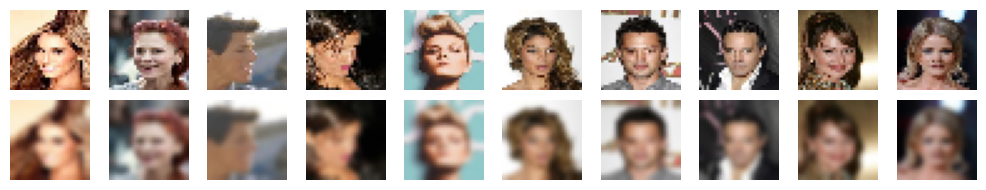

In [28]:
plot_rows(x_train[:10], x_train_blur[:10])

## Normalizing the data

In [8]:
mu, std = np.mean(x_train, axis=(0, 1, 2)), np.std(x_train, axis=(0, 1, 2))
print("mu: ", mu, " sigma: ", std)

def norm(a):
    return torch.from_numpy((a - mu) / std).permute(0, 3, 1, 2)

def denorm(a):
    return a.detach().cpu().permute(0, 2, 3, 1).numpy() * std + mu

x_train_normed = norm(x_train)
x_valid_normed = norm(x_valid)
x_train_blur_normed = norm(x_train_blur)
x_valid_blur_normed = norm(x_valid_blur)

mu:  [0.34133333 0.34133333 0.34133333]  sigma:  [0.32654327 0.27426648 0.2628333 ]


## Now we build the de-noising auto-encoder model

* Over-complete auto-encoder (i.e latent represent is of higher dimensionality than the input)
* Use of transposed convolution in decoder (torch ConvTranspose2d)
* Start with 2 convolutional layers each for encoder & decoder

In [44]:
def build_model():
  layers = []
  # Encoder
  layers.append(nn.Conv2d(3, 16, 3))
  layers.append(nn.ReLU())
  layers.append(nn.Conv2d(16, 64, 3))
  layers.append(nn.ReLU())
  # Decoder
  layers.append(nn.ConvTranspose2d(64, 64, 3))
  layers.append(nn.ReLU())
  layers.append(nn.ConvTranspose2d(64, 16, 3))
  layers.append(nn.ReLU())
  layers.append(nn.Conv2d(16, 3, 1, 1))

  model = nn.Sequential(*layers)

  return model

## Loading data for training

In [34]:
train_data = list(zip(x_train_blur_normed, x_train_normed))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)

valid_data = list(zip(x_valid_blur_normed, x_valid_normed))
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True, num_workers=4)

## Now lets train the auto-encoder

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch: 0, mse loss (train/valid): 0.1520/0.0727
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


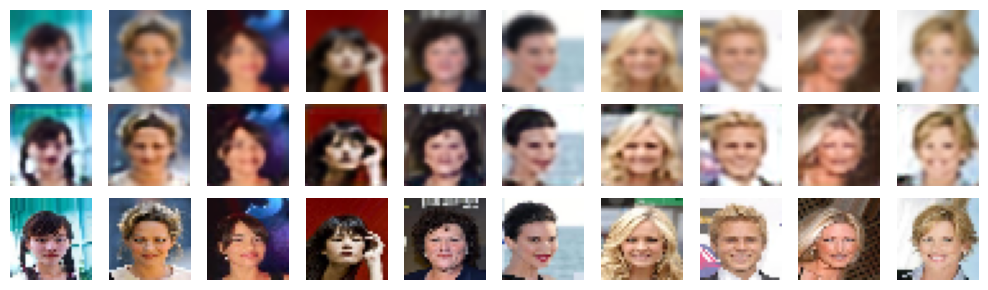

epoch: 1, mse loss (train/valid): 0.0609/0.0543
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


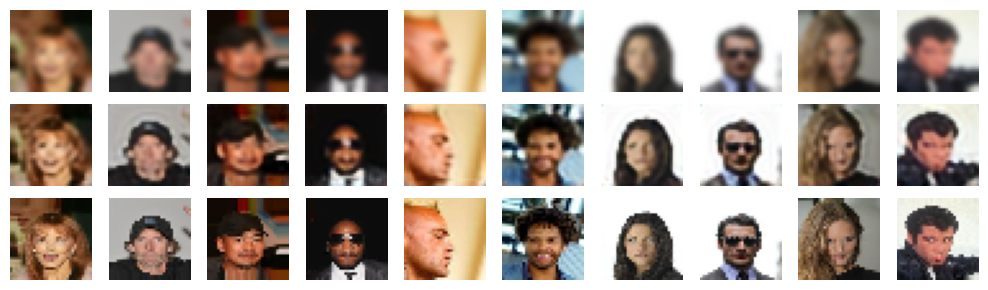

epoch: 2, mse loss (train/valid): 0.0500/0.0473
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


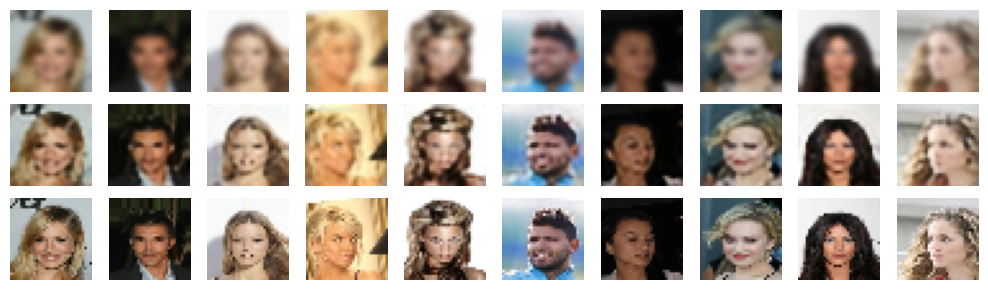

epoch: 3, mse loss (train/valid): 0.0444/0.0424
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


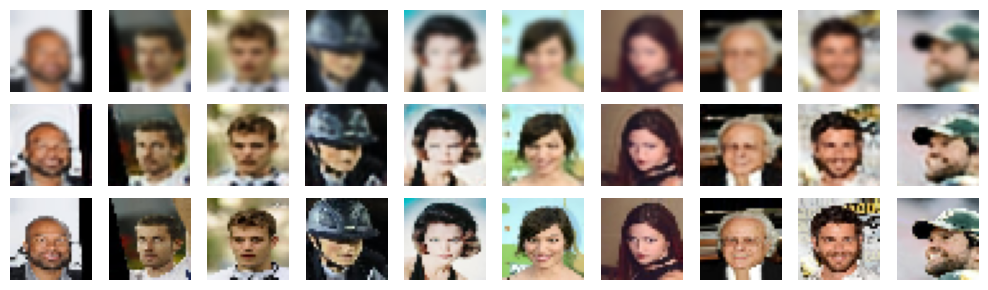

epoch: 4, mse loss (train/valid): 0.0407/0.0398
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


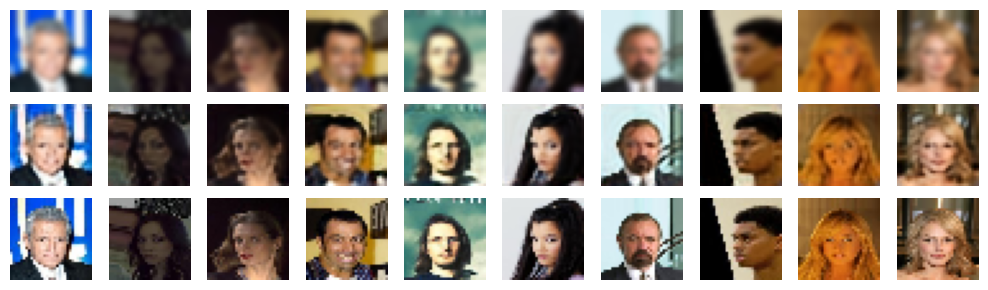

epoch: 5, mse loss (train/valid): 0.0378/0.0369
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


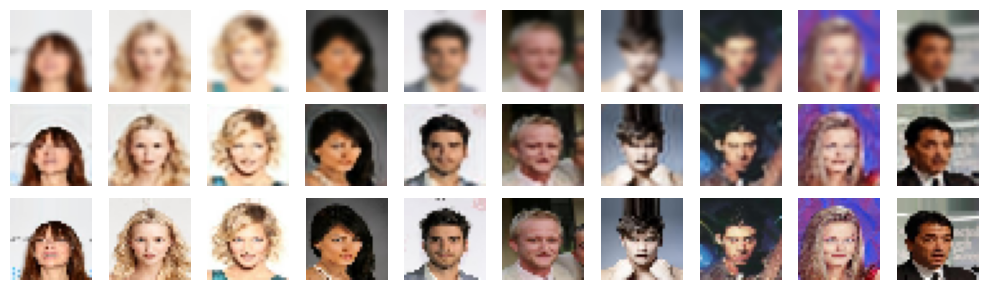

epoch: 6, mse loss (train/valid): 0.0355/0.0348
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


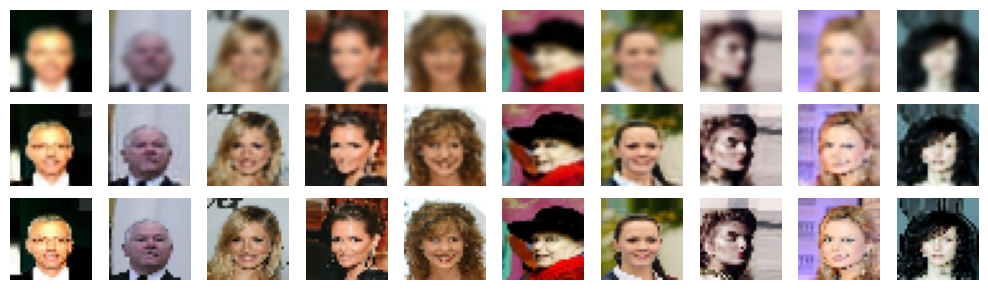

epoch: 7, mse loss (train/valid): 0.0338/0.0333
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


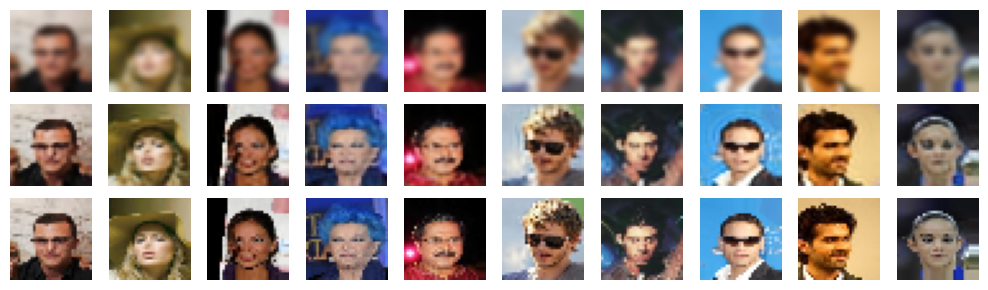

epoch: 8, mse loss (train/valid): 0.0323/0.0325
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


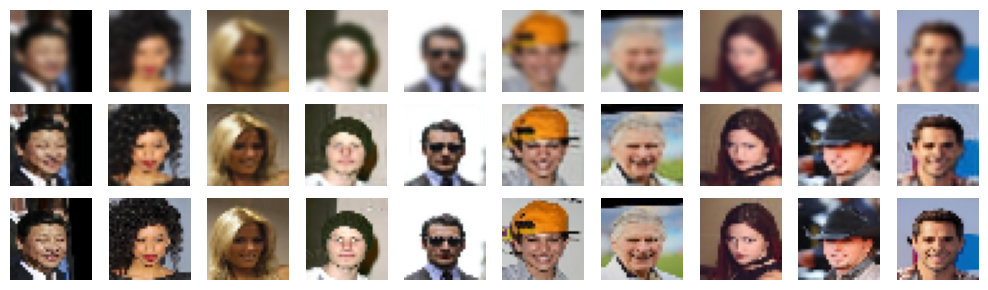

epoch: 9, mse loss (train/valid): 0.0312/0.0372
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


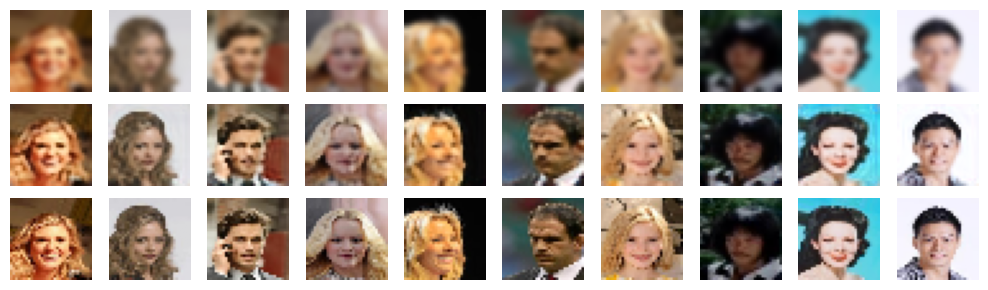

epoch: 10, mse loss (train/valid): 0.0303/0.0299
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


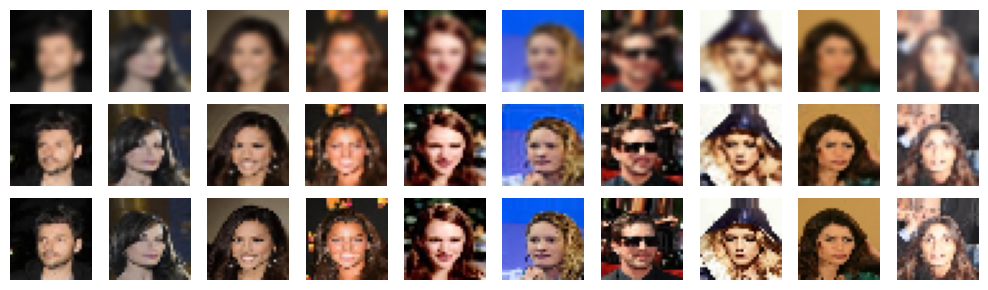

epoch: 11, mse loss (train/valid): 0.0293/0.0290
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


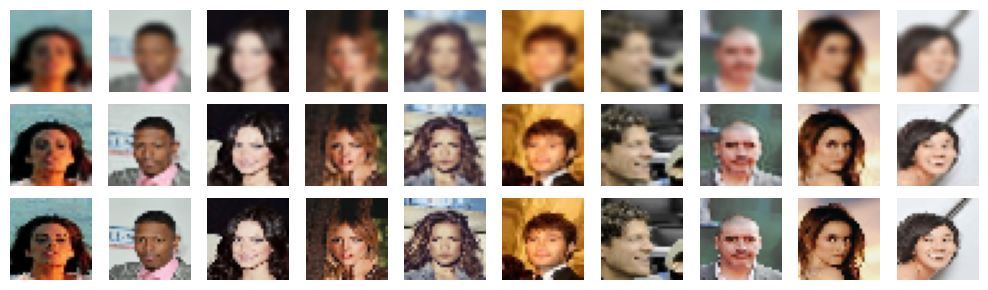

epoch: 12, mse loss (train/valid): 0.0286/0.0285
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


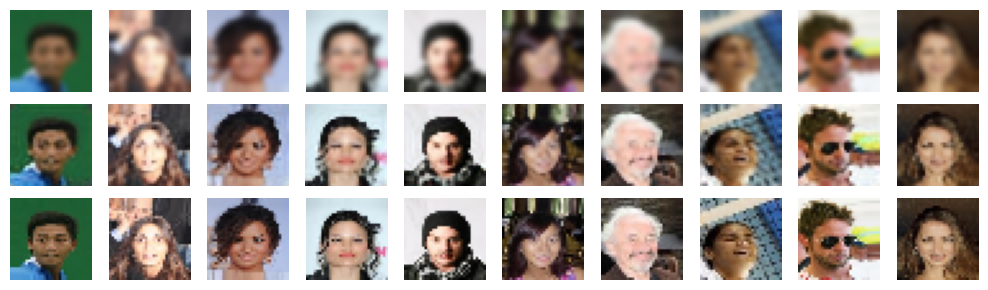

epoch: 13, mse loss (train/valid): 0.0281/0.0284
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


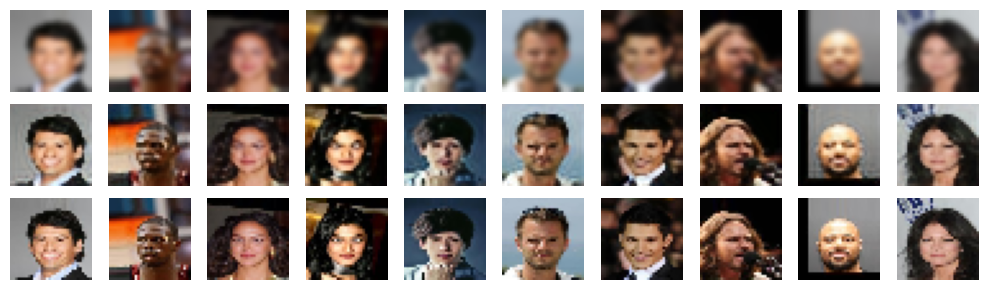

epoch: 14, mse loss (train/valid): 0.0274/0.0275
Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)


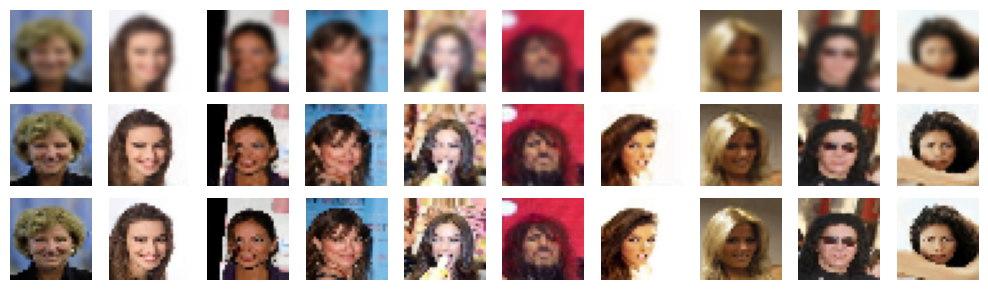

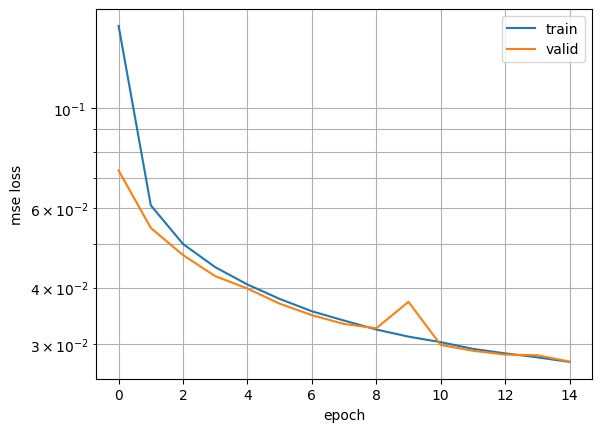

In [46]:
model = build_model().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
valid_losses = []

for epoch in tqdm(range(15)):
    losses = []
    for x, y in train_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    train_losses.append(np.mean(losses))

    losses = []
    for x, y in valid_dataloader:
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y)
        losses.append(loss.item())
    valid_losses.append(np.mean(losses))

    print(f'epoch: {epoch}, mse loss (train/valid): {train_losses[-1]:.4f}/{valid_losses[-1]:.4f}')
    print('Row wise: blurred (input), reconstructed (output), original (gt). (on validation set)')
    plot_rows(denorm(x[:10]), denorm(y_hat[:10]), denorm(y[:10]), scale=1)

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.grid(which='both')
plt.legend()
plt.show()